# HBV tests

In [227]:
using PyPlot
using Distributions

## Initilization

**Read input data:**

In [228]:
data = readdlm(string(Pkg.dir("Vann"),"\\data_airgr\\test_data.txt"), ',', header = true);

prec  = data[1][1:2000,1];
epot  = data[1][1:2000,2];
q_obs = data[1][1:2000,3];

**mdata:**

In [229]:
sm  = 10.;
suz = 40.;
slz = 30.;
st_uh = zeros(Float64,20);

**Parameter values:**

In [230]:
fc = 50.;      # Check that sm <= fc & fc > 0
lp = 0.5;      # 0.5 < lp < 1
k0 = 0.05;     # 0 < k0 < 1
k1 = 0.05;     # 0 < k1 < 1
k2 = 0.01;     # 0 < k2 < 1
beta = 1.;     # 1 < beta < 5 (100 nisse)
perc = 2.;     # perc > 0
ulz = 30.;     # ulz > 0
maxbas = 5.;   # 1 <= maxbas <= 20 

5.0

## Routing - unit hydrograph

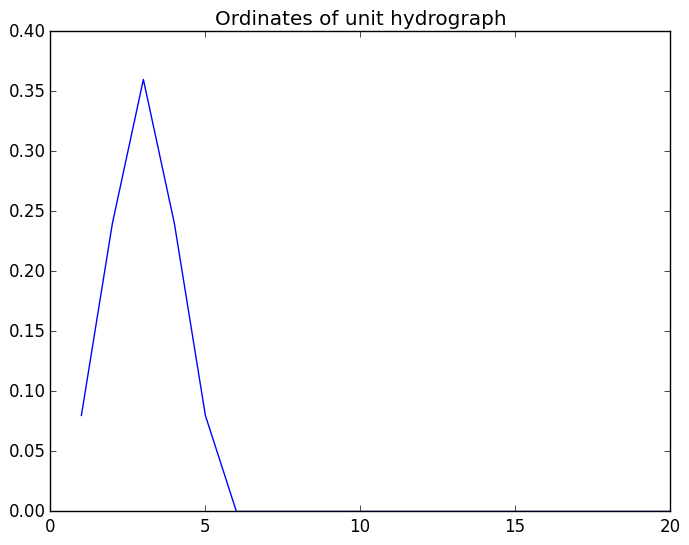

In [242]:
# Cumulative unit hydrograph

triang = TriangularDist(0, maxbas);

triang_cdf = cdf(triang, 0:20)

hbv_ord = diff(triang_cdf);

plot(1:length(hbv_ord), hbv_ord);
title("Ordinates of unit hydrograph");

## Model

In [232]:
# Initilize output

q_out   = zeros(Float64, length(prec));
sm_out  = zeros(Float64, length(prec));
suz_out = zeros(Float64, length(prec));
slz_out = zeros(Float64, length(prec));

In [233]:
# Initilize variables due to local scope of for loops

f_recharge = 0.;
recharge = 0.;
eact = 0.;
perc_now = 0.;
q_tot = 0.;
q_suz = 0.;

In [234]:
# Loop over time

for i in eachindex(prec)
  
  # Input for current time step
  
  prec_now = prec[i]
  epot_now = epot[i]
  
  # Soil moisture zone (assume no evaporation during rainfall)
  
  if prec_now > 0.
    
    # Beta function
    
    f_recharge = (sm / fc) ^ beta;
    
    # Groundwater recharge
    
    recharge = f_recharge * prec_now;
    
    # Update soil moisture zone
    
    sm = sm + prec_now - recharge;
    
    # Add excess soil moisture to groundwater recharge
    
    if sm > fc
      recharge += sm - fc;
      sm = fc;        
    end    
    
    # No evapotranspiration
    
    eact = 0.;    
    
  else
    
    # Compute actual evapotranspiration
    
    eact = epot_now * min(sm/(fc*lp), 1.)
    
    # Update soil moisture zone
    
    sm = sm - eact;
    
    # Check limits for soil moisture zone
    
    if sm < 0.
      eact = max(eact + sm, 0.);
      sm = 0.;    
    end    
    
    # No groundwater recharge
    
    recharge = 0.;    
    
  end
  
  # Add recharge to upper groundwater box
  
  suz = suz + recharge;
  
  # Remove percolation from upper groundwater box
  
  perc_now = min(perc, suz);
  
  suz = suz - perc_now;
  
  # Compute runoff from upper groundwater box and update storage
  
  q_suz = k1 * suz + k0 * max(suz-ulz, 0);
  
  suz = suz - q_suz;
  
  if suz < 0.
    q_suz = max(q_suz + suz, 0.);
    suz = 0.
  end    
  
  # Add precolation to lower groundwater box
  
  slz = slz + perc_now;
  
  # Compute runoff from lower groundwater box and update storage
  
  q_slz = k2 * slz;
  
  slz = slz - q_slz;
  
  # Convolution of unit hydrograph
  
  q_tmp = q_suz + q_slz;
  
  nh = length(hbv_ord);
  
  for k = 1:nh-1
    st_uh[k] = st_uh[k+1] + hbv_ord[k]*q_tmp;
  end
  
  st_uh[nh] = hbv_ord[nh] * q_tmp;
  
  # Compute total runoff
  
  q_tot = st_uh[1];
  
  # Store results
  
  q_out[i]   = q_tot;
  sm_out[i]  = sm;
  suz_out[i] = suz;
  slz_out[i] = slz;    
  
end

# Print final results

println("---- Results ----")

println("f_recharge = $f_recharge")

println("recharge = $recharge")

println("sm = $sm")

println("eact = $eact")

println("suz = $suz")

println("perc_now = $perc_now")

println("q_suz = $q_suz")

println("slz = $slz")

println("st_uh = $st_uh")

println("q_tot = $q_tot")

---- Results ----
f_recharge = 0.8126363519562645
recharge = 28.92985412964302
sm = 47.301963468170214
eact = 0.0
suz = 46.28579900002539
perc_now = 2.0
q_suz = 3.4761998888917107
slz = 186.5199903709095
st_uh = [3.05766,3.31062,2.90645,1.53322,0.428819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
q_tot = 3.0576574191526786


## Plot results

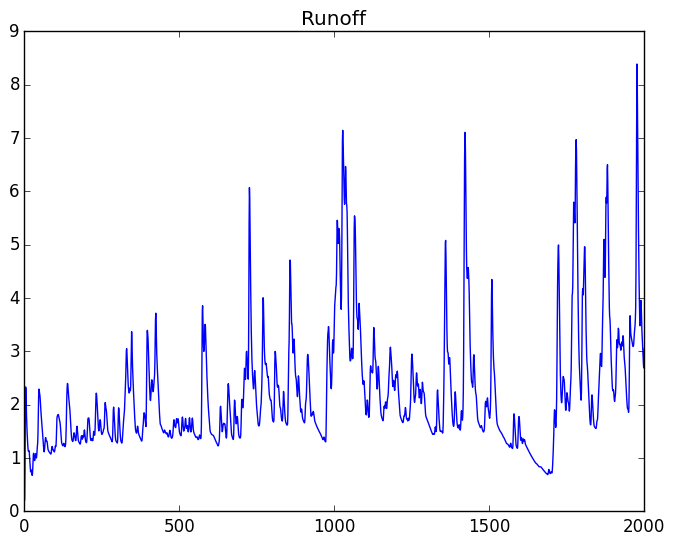

In [235]:
plot(1:length(q_out), q_out, color="blue", linewidth=1.0, linestyle="-");
title("Runoff");

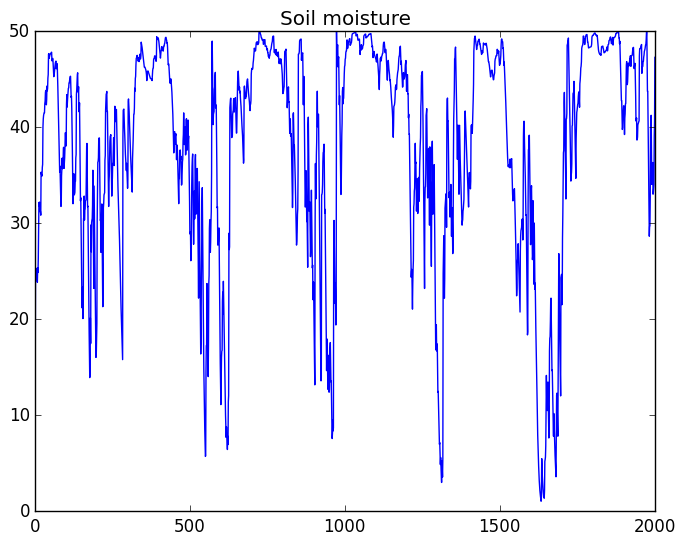

In [236]:
plot(1:length(sm_out), sm_out, color="blue", linewidth=1.0, linestyle="-");
title("Soil moisture");

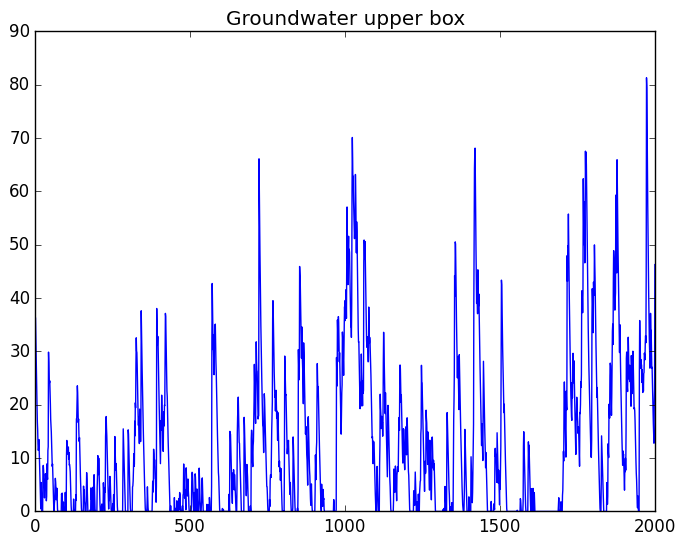

In [237]:
plot(1:length(suz_out), suz_out, color="blue", linewidth=1.0, linestyle="-");
title("Groundwater upper box");

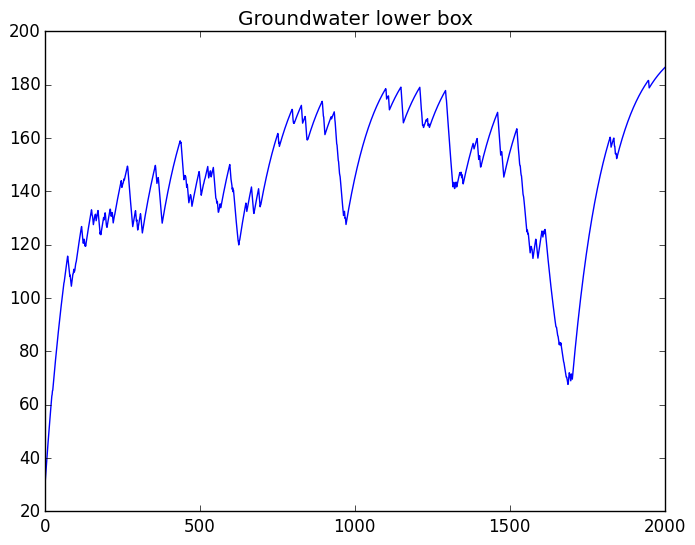

In [238]:
plot(1:length(slz_out), slz_out, color="blue", linewidth=1.0, linestyle="-");
title("Groundwater lower box");

In [ ]:
param = [50., 0.5, 0.05, 0.05, 0.01, 1., 2., 30., 5.]

fc     = param[1];
lp     = param[2];
k0     = param[3];
k1     = param[4];
k2     = param[5];
beta   = param[6];
perc   = param[7];
ulz    = param[8];
maxbas = param[9];